In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import geopandas as gpd  # If needed for mapping

# Define real-world taxi hotspots in Oslo (latitude, longitude)
taxi_hotspots = np.array([
    (59.904134, 10.685336),  # Vikingskipshuset
    (59.912994, 10.734517),  # Oslo Rådhus
    (59.912725, 10.746234),  # Oslo Domkirke
    (59.838723, 10.796780),  # Norsk Maritimt kurssenter
    (59.948041, 10.643363),  # Røa Senter
    (59.936867, 10.736847),  # Ullevåll Sjukehus
    (59.934680, 10.870995),  # Ikea Furuset
    (59.907759, 10.755086),  # Operahuset
    (59.964603, 10.666482),  # Skimuseet Holmenkollen
    (59.966446, 10.781785)   # Teknisk Museum Kjelsås
])

# Generate 10 customer locations in Oslo (latitude, longitude)
np.random.seed(43)
customer_locations = np.column_stack((
    np.random.uniform(59.83, 59.97, 10),  # Latitude range for Oslo
    np.random.uniform(10.64, 10.88, 10)   # Longitude range for Oslo
))

# Compute Euclidean distance matrix
distance_matrix = cdist(taxi_hotspots, customer_locations, metric='euclidean')

# Print first 5 distances for verification
print("First 5 distances (km):\n", np.round(distance_matrix[:5, :5], 3))


First 5 distances (km):
 [[0.076 0.148 0.058 0.051 0.165]
 [0.067 0.098 0.073 0.095 0.119]
 [0.068 0.086 0.078 0.105 0.108]
 [0.062 0.084 0.096 0.145 0.063]
 [0.137 0.192 0.115 0.085 0.217]]


In [20]:
class BinaryPSO_TaskAssignment:
    def __init__(self, distance_matrix, num_particles=100, max_iter=200, inertia=0.8, cognitive=1.5, social=1.5):
        self.distance_matrix = distance_matrix
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.inertia = inertia
        self.cognitive = cognitive
        self.social = social
        self.num_taxis = len(distance_matrix)

        # Initialize binary particles (assignment matrices)
        self.particles = [self.random_binary_assignment() for _ in range(self.num_particles)]
        self.velocities = [np.zeros((self.num_taxis, self.num_taxis)) for _ in range(self.num_particles)]

        # Personal bests
        self.p_best = list(self.particles)
        self.p_best_costs = [self.assignment_cost(matrix) for matrix in self.particles]

        # Global best
        self.g_best = self.p_best[np.argmin(self.p_best_costs)]
        self.g_best_cost = min(self.p_best_costs)

        # Store convergence history
        self.best_costs = []

    def random_binary_assignment(self):
        """Generate a valid random binary assignment matrix (N x N)"""
        matrix = np.zeros((self.num_taxis, self.num_taxis))
        perm = np.random.permutation(self.num_taxis)
        for i in range(self.num_taxis):
            matrix[i, perm[i]] = 1
        return matrix

    def assignment_cost(self, assignment):
        """Calculate the total distance for a given binary assignment matrix"""
        cost = np.sum(self.distance_matrix * assignment)
        return cost

    def sigmoid(self, x):
        """Sigmoid for binary PSO probability conversion"""
        return 1 / (1 + np.exp(-x))

    def update_velocity(self, velocity, pbest, gbest, particle):
        """Update velocity matrix based on PSO velocity equation"""
        r1, r2 = np.random.rand(), np.random.rand()
        new_velocity = (
            self.inertia * velocity
            + self.cognitive * r1 * (pbest - particle)
            + self.social * r2 * (gbest - particle)
        )
        return new_velocity

    def update_position(self, particle, velocity):
        """Update the binary assignment matrix with a valid one-to-one mapping"""
        probability = self.sigmoid(velocity)

       
        new_particle = (np.random.rand(self.num_taxis, self.num_taxis) < probability).astype(int)

        # Ensure one-to-one assignment using the Hungarian Algorithm
        from scipy.optimize import linear_sum_assignment

        row_ind, col_ind = linear_sum_assignment(-new_particle)  # Maximize assignment
        valid_assignment = np.zeros_like(new_particle)

        for i in range(len(row_ind)):
            valid_assignment[row_ind[i], col_ind[i]] = 1  # Assign one taxi per customer

        return valid_assignment

    def optimize(self, stop_threshold=20):
        """Run the Binary PSO optimization process"""
        no_improve_count = 0
        last_best_cost = self.g_best_cost

        for iteration in range(self.max_iter):
            for i in range(self.num_particles):
                self.velocities[i] = self.update_velocity(self.velocities[i], self.p_best[i], self.g_best, self.particles[i])
                self.particles[i] = self.update_position(self.particles[i], self.velocities[i])
                new_cost = self.assignment_cost(self.particles[i])

                # Update personal best
                if new_cost < self.p_best_costs[i]:
                    self.p_best[i] = self.particles[i]
                    self.p_best_costs[i] = new_cost

                # Update global best
                if new_cost < self.g_best_cost:
                    self.g_best = self.particles[i]
                    self.g_best_cost = new_cost

            self.best_costs.append(self.g_best_cost)

            # Stopping condition
            if self.g_best_cost < last_best_cost:
                last_best_cost = self.g_best_cost
                no_improve_count = 0
            else:
                no_improve_count += 1

            if no_improve_count >= stop_threshold:
                print(f"Stopped early at iteration {iteration} (no improvement in {stop_threshold} iterations)")
                break

            # Print progress every 10 iterations
            if iteration % 10 == 0 or iteration == self.max_iter - 1:
                print(f"Iteration {iteration}: Best Cost = {self.g_best_cost:.5f}")

        return self.g_best, self.g_best_cost, self.best_costs


In [21]:
# Run the improved Binary PSO
pso_solver = BinaryPSO_TaskAssignment(distance_matrix, num_particles=100, max_iter=200)
best_assignment, best_cost, cost_history = pso_solver.optimize()


Iteration 0: Best Cost = 0.67759
Iteration 10: Best Cost = 0.56408
Iteration 20: Best Cost = 0.56408
Iteration 30: Best Cost = 0.55864
Iteration 40: Best Cost = 0.55235
Iteration 50: Best Cost = 0.55235
Iteration 60: Best Cost = 0.54929
Iteration 70: Best Cost = 0.54718
Iteration 80: Best Cost = 0.54718
Stopped early at iteration 90 (no improvement in 20 iterations)


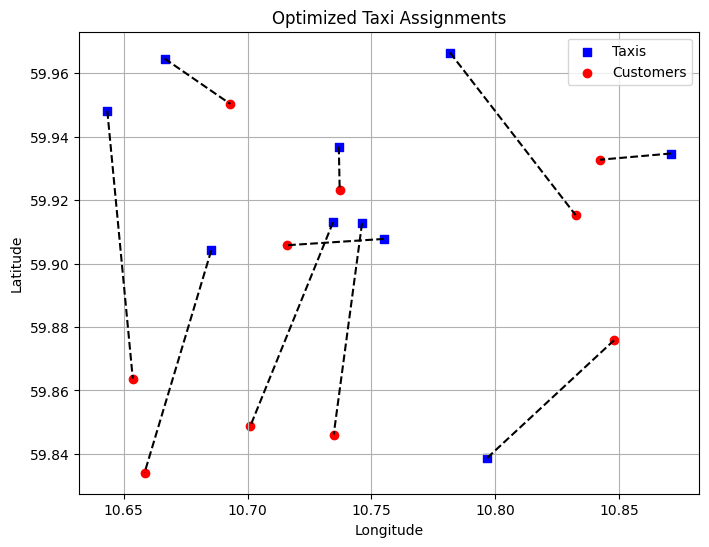

In [22]:
plot_assignments(taxi_hotspots, customer_locations, best_assignment)
